In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Attention
from keras_self_attention import SeqSelfAttention


2022-12-11 14:41:06.609018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load Dataset
ME_phenotypes = pd.read_csv('TripleStressME_phenotypes.csv')
ME_protemo=pd.read_csv('TripleStressME_proteome.csv')

In [3]:
#building an Random Forest regressor to 
# 1. Predict growth rate for a given Stress Combination
# 2. Extract feature importance (e.g. which stress has more impact on growth rate)
# input : stress 
# output: growthrate 

ME_phenotypes.drop(columns=['Stress'])

X_tree = ME_phenotypes.iloc[:,1:4]
y_tree = ME_phenotypes.iloc[:,4]

Stress =X_tree.columns

X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size = 0.2, random_state = 0)
regr = RandomForestRegressor()

parameters = {
    'max_depth': [5, 10, 20],
    'n_estimators': [50, 100, 200]
}
gridforest = GridSearchCV(regr, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train.ravel())

gridforest.best_params_


Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'max_depth': 20, 'n_estimators': 200}

In [4]:
#fitting a random forest regressor model and determine model accuracy

tree_regr = RandomForestRegressor(n_estimators = 200, max_depth = 20, random_state =0)

tree_regr.fit(X_train, y_train.ravel())

regr_predictions = tree_regr.predict(X_test)

mae = mean_absolute_error(y_test.ravel(), regr_predictions)

mse = mean_squared_error(y_test.ravel(), regr_predictions)

r2 = r2_score(y_test.ravel(), regr_predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared scores:', r2)

Mean Absolute Error: 0.008214862992800942
Mean Squared Error: 0.00018483594096554574
R-squared scores: 0.9984328478471879


In [5]:
#Determine feature importance in the Stress conditions

Stress_importance = tree_regr.feature_importances_
for i,v in enumerate(Stress_importance):print('Feature: %0d, Score: %.5f' % (i,v))

Stress_importance = pd.DataFrame(Stress_importance,columns=['Stress_importance'], index=Stress)

Stress_importance=Stress_importance.sort_values(by='Stress_importance', ascending=False)

Stress_importance.head(10)

Feature: 0, Score: 0.58928
Feature: 1, Score: 0.28871
Feature: 2, Score: 0.12201


,Stress_importance
T,0.589285
pH,0.288710
ROS,0.122006


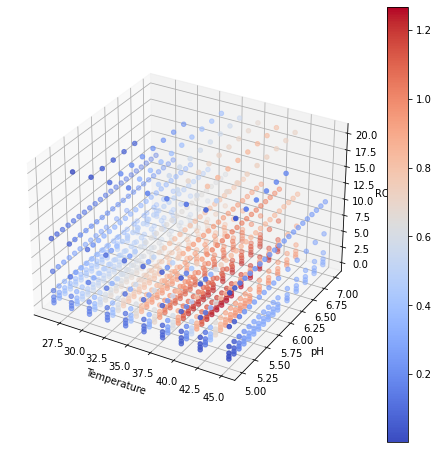

<Figure size 432x288 with 0 Axes>

In [6]:
#Visualize stress vs growth rate in 3-d space

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d',xlabel='Temperature',ylabel='pH', zlabel='ROS')

x_ = ME_phenotypes.iloc[:,1]
y_ = ME_phenotypes.iloc[:,2]
z_ = ME_phenotypes.iloc[:,3]
c_ = ME_phenotypes.iloc[:,4]

img = ax.scatter(x_, y_, z_, c=c_, cmap='coolwarm')
fig.colorbar(img)
plt.show()

plt.savefig("stress_vs_growthrate_3d.jpeg")

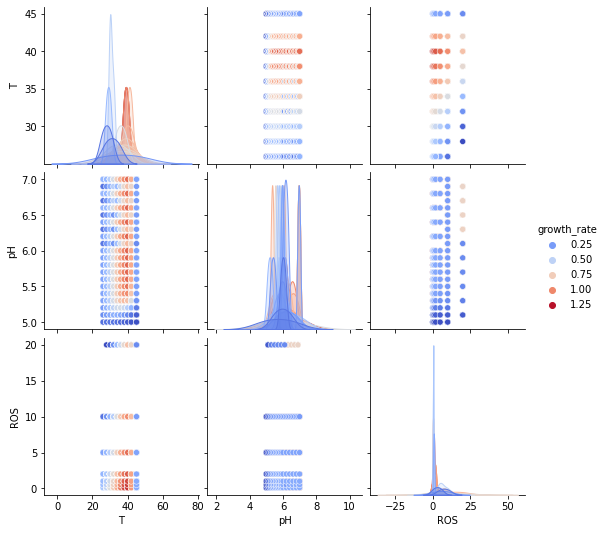

In [7]:
#Visualize stress correleation in pairplot

sns.pairplot(
    ME_phenotypes,  
    x_vars=["T", "pH", "ROS"],
    hue="growth_rate",
    palette='coolwarm',
)
plt.savefig('stress_pairplot.jpeg')


In [8]:
#stats info of growthrate array
# we can see that the mean is appriximately equal to the median, indicating data distribution is symmatric 
y_tree.describe()

count    1077.000000
mean        0.617274
std         0.333314
min         0.003723
25%         0.334351
50%         0.613525
75%         0.900635
max         1.266174
Name: growth_rate, dtype: float64

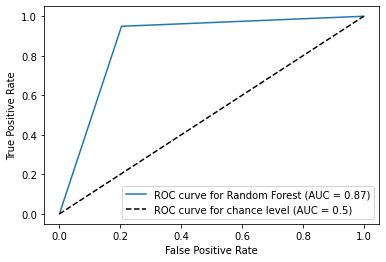

<Figure size 432x288 with 0 Axes>

In [9]:
# We can build a Random Forest Classifier to find the Stress boundary conditions for "High" and "Low" Growth rate
# Covert growthrate to binary:
# High growth rate = 1, when > 0.617
# Low growth rate = 1, when < 0.617

y_tree_binary=np.where(y_tree<0.617,0,1)

X_train_clf, X_test_clf, y_train_binary, y_test_binary = train_test_split(X_tree, y_tree_binary, test_size = 0.2, random_state = 0)

tree_clf = RandomForestClassifier(max_depth=3, random_state=0)
tree_clf.fit(X_train_clf, y_train_binary)

#Getting AUC metrics for the classifier

y_pred_proba = tree_clf.predict(X_test_clf)
fpr, tpr, _ = metrics.roc_curve(y_test_binary,  y_pred_proba)

ROC_tree_clf = roc_auc_score(y_test_binary, tree_clf.predict(X_test_clf))

plt.plot(fpr,tpr, label= f"ROC curve for Random Forest (AUC = {ROC_tree_clf:.2f})")
plt.plot([0, 1], [0, 1], "k--", label=f"ROC curve for chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
plt.savefig('ROC_curve_for_Random_Forest_Clf.jpeg')

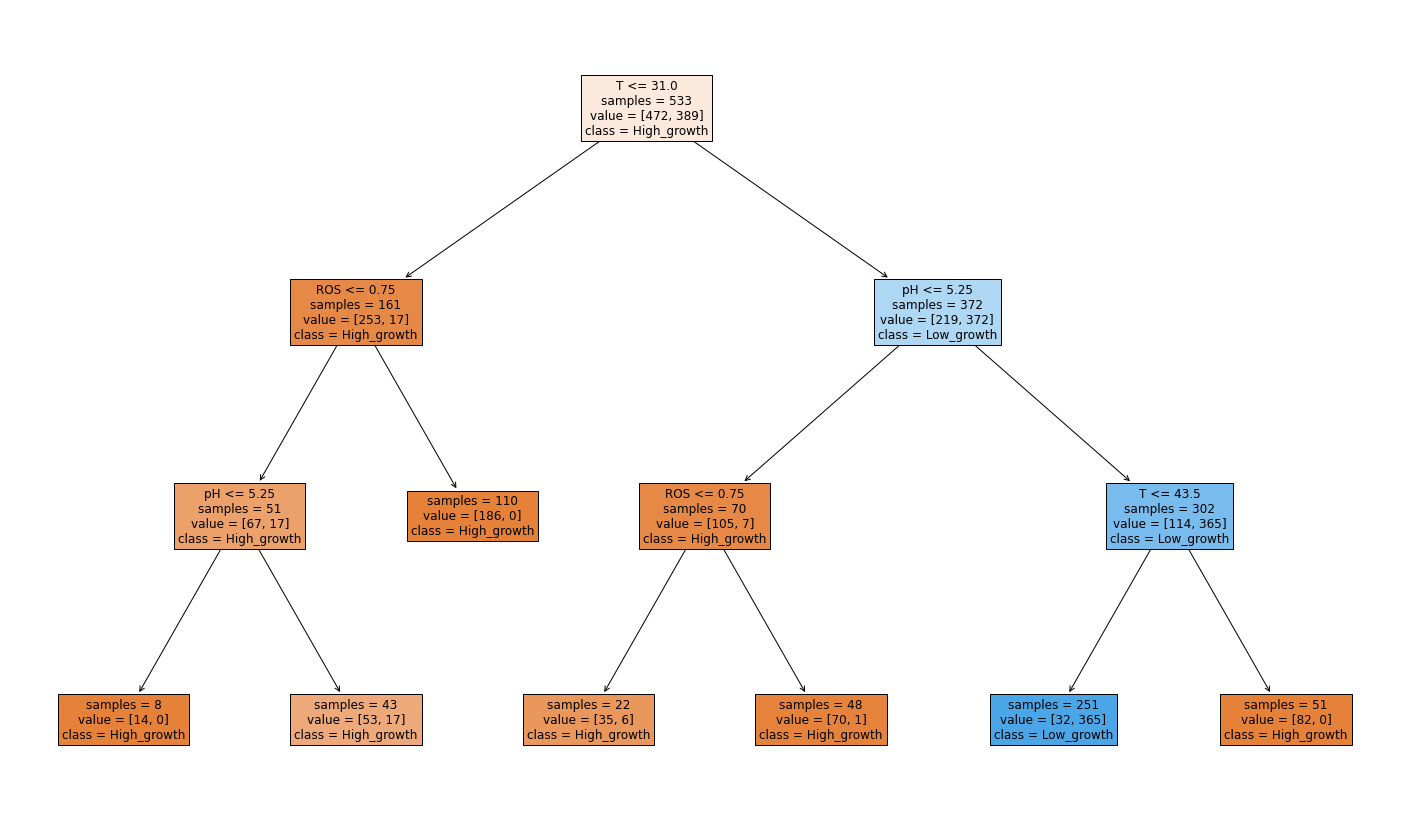

In [10]:
# Construct a sample tree plot
fig4 = plt.figure(figsize=(25,15))
plot_tree(tree_clf.estimators_[1],max_depth=4, fontsize=12,feature_names=['T','pH','ROS'], class_names=['High_growth','Low_growth'],impurity=False,filled=True)
plt.savefig('growth_rate_tree_plot.jpeg')


In [11]:
#Analysis of Protemo + Phenotypes data
#Data Pre-processing - Mergeing Phenotypes & Protemo Matrix

print('The shape of Phenotypes Matrix is:',ME_phenotypes.shape)
print('The shape of Protemo Matrix is:',ME_protemo.shape)
ME_merged = ME_phenotypes.merge(ME_protemo, on='Stress', how='inner')
print('The shape of Merged Matrix is:',ME_merged.shape)
ME_cleaned=ME_merged.drop(columns=['Stress','T_y','pH_y','ROS_y','growth_rate'])


The shape of Phenotypes Matrix is: (1077, 5)
The shape of Protemo Matrix is: (1077, 691)
The shape of Merged Matrix is: (1077, 695)


In [12]:
#Train - Test Split

X_MLP = ME_cleaned.iloc[:,0:3].values.astype(float)
y_MLP = ME_cleaned.iloc[:,3:].values.astype(float)

#Try to use logarithmic dataset but did not improve the model much
#y_log = np.where(y_log > 0.0000000001, y_log, -10)
#y_log = np.log10(y_log, out=y_log, where=y_log > 0)

X_train, X_test, y_train, y_test = train_test_split(X_MLP, y_MLP, test_size=0.2, random_state=0)
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
print("Train data shape: %r, Train target shape: %r" % (X_train.shape, y_train.shape))
print( "Test data shape: %r, Test target shape: %r" % (X_test.shape, y_test.shape))
print ("Train-Test Ratio: %.2f-%.2f" % (np.true_divide(X_train.shape[0],X_MLP.shape[0]),
                                                np.true_divide(X_test.shape[0],X_MLP.shape[0])))

X_train_scaled.reshape(861,3,1)
y_train.reshape(861,687,1)



Train data shape: (861, 3), Train target shape: (861, 687)
Test data shape: (216, 3), Test target shape: (216, 687)
Train-Test Ratio: 0.80-0.20


array([[[6.48000000e-05],
        [2.20806000e-04],
        [8.22000000e-07],
        ...,
        [1.38000000e-08],
        [1.18000000e-08],
        [9.95003200e-02]],

       [[0.00000000e+00],
        [2.68844800e-03],
        [8.29000000e-06],
        ...,
        [1.66000000e-07],
        [1.41000000e-07],
        [1.01180680e-01]],

       [[0.00000000e+00],
        [3.57799600e-03],
        [9.53000000e-06],
        ...,
        [1.98000000e-07],
        [1.69000000e-07],
        [9.84538960e-02]],

       ...,

       [[5.70606000e-04],
        [2.07991600e-03],
        [7.12000000e-06],
        ...,
        [1.39000000e-07],
        [1.18000000e-07],
        [1.01464213e-01]],

       [[8.26883000e-04],
        [3.12228600e-03],
        [9.98000000e-06],
        ...,
        [2.01000000e-07],
        [1.71000000e-07],
        [9.86569220e-02]],

       [[7.70983000e-04],
        [2.85554600e-03],
        [9.45000000e-06],
        ...,
        [1.89000000e-07],
        [1.6100

In [59]:
#Setting up a DEEP Nueral Network using MultiLayer Perceptron MLP
#Performing regression on Protemo data at various stress
#Use SOFTMAX in output layer to force all fluxes add up to 1

#input: Stress
#Target: Protemo Flux

#The aim for this NN is to: provide accurate predictions of protemo flux for a given Enviromental Stree combinations

input_shape = (3,) 
model=Sequential()
model.add(Dense(3, input_shape=input_shape, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))

model.add(Dense(687, activation='softmax'))

#model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error','accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 3)                 12        
                                                                 
 dense_11 (Dense)            (None, 64)                256       
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 687)               44655     
                                                                 
Total params: 61,499
Trainable params: 61,499
Non-trainable params: 0
_________________________________________________________________


In [60]:
history= model.fit(X_train_scaled,
                   y_train,
                   epochs=1000,
                   batch_size=100,
                   verbose=1,
                   validation_data=(X_test_scaled,y_test))

model.save_weights("weights.txt")

Epoch 1/1000
9/9 [==============================] - 2s 41ms/step - loss: 0.0022 - mean_squared_error: 1.1047e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_mean_squared_error: 1.0644e-04 - val_accuracy: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0022 - mean_squared_error: 1.1038e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_mean_squared_error: 1.0633e-04 - val_accuracy: 0.0000e+00
Epoch 3/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0022 - mean_squared_error: 1.1026e-04 - accuracy: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 1.0620e-04 - val_accuracy: 0.0046
Epoch 4/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0021 - mean_squared_error: 1.1009e-04 - accuracy: 0.0151 - val_loss: 0.0021 - val_mean_squared_error: 1.0600e-04 - val_accuracy: 0.0231
Epoch 5/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0021 - mean_squared_error: 1.0979e-04 - accuracy: 0.0221 - val_lo

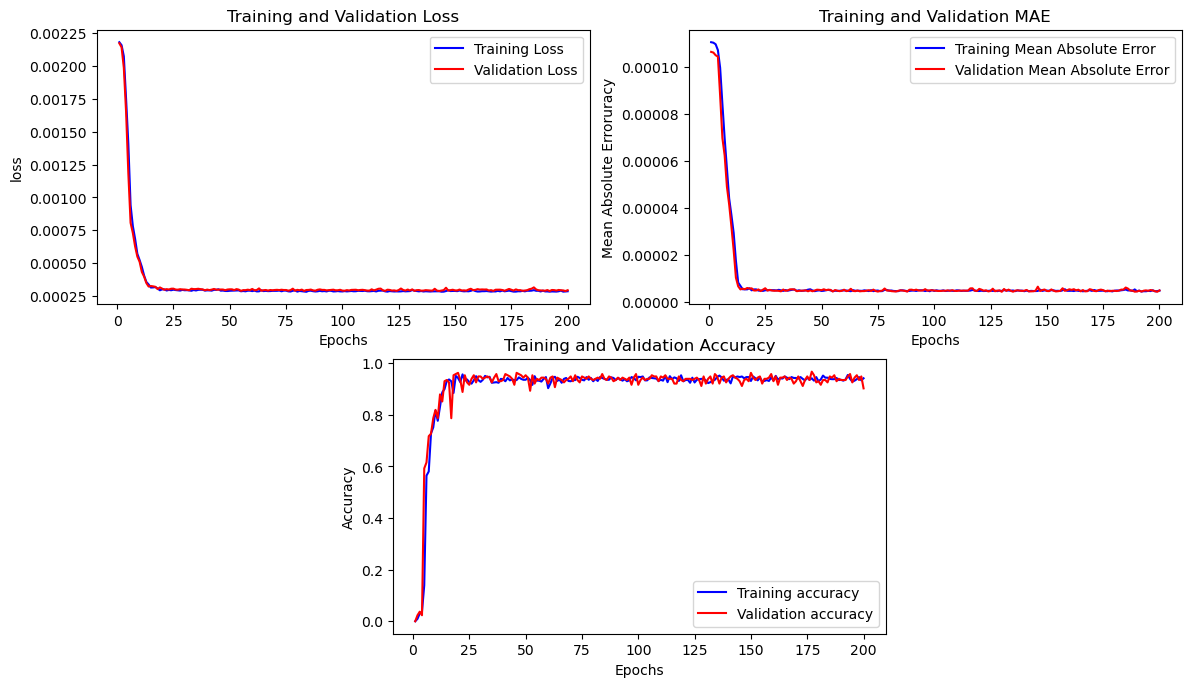

In [15]:
#Generate Metrics plots for MLP LOSS, MSE, Accuracy

fig, ax = plt.subplots(3, figsize=(14,8),dpi=100)

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

loss = history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
ax1.plot(epochs,loss,'b',label='Training Loss')
ax1.plot(epochs,val_loss,'red', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('loss')
ax1.legend()

MAE= history.history['mean_squared_error']
val_MAE = history.history['val_mean_squared_error']
ax2.plot(epochs, MAE, 'blue', label= 'Training Mean Absolute Error')
ax2.plot(epochs, val_MAE , 'red', label= 'Validation Mean Absolute Error')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Absolute Erroruracy')
ax2.legend()

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
ax3.plot(epochs, acc, 'blue', label= 'Training accuracy')
ax3.plot(epochs, val_acc , 'red', label= 'Validation accuracy')
ax3.set_title('Training and Validation Accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()

plt.savefig('MLP_Scores.jpeg')


In [16]:
#Checking R^2 SCORE
#CHecking total protein flus (must add up to 1)

predictions = model.predict(X_test_scaled)
total_error = tf.reduce_sum(tf.square(tf.subtract(y_test, tf.reduce_mean(y_test))))
unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_test, predictions)))
R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error)) 

print("The R^2 is ",R_squared)

prediction = model.predict(X_test_scaled[:1])
df1 = ME_cleaned.drop(columns=['T_x','pH_x','ROS_x'])

print('Check total protein fraction:',prediction.sum())

Predicted_df = pd.DataFrame(prediction, columns=df1.columns)
Target_df = pd.DataFrame(y_test[:1], columns=df1.columns)
Results_df = pd.concat([Predicted_df,Target_df]).T
Results_df.columns = ['Predicted Values', 'Target Values']
Results_df.head(20)

#Results_df.plot.bar(figsize=(30,10))

7/7 [==============================] - 0s 2ms/step
The R^2 is  tf.Tensor(0.9543909450306677, shape=(), dtype=float64)
1/1 [==============================] - 0s 32ms/step
Check total protein fraction: 1.0000001


,Predicted Values,Target Values
b0002,8.257243e-05,0.000000e+00
b0003,3.124878e-03,3.556376e-03
b0004,9.278358e-06,1.020000e-05
b0007,9.097097e-07,0.000000e+00
b0009,1.602017e-06,0.000000e+00
b0014,4.322857e-04,4.407214e-03
b0015,3.310792e-05,3.624160e-04
b0023,1.284547e-03,1.349808e-03
b0025,6.676443e-05,5.930000e-05
b0026,2.595968e-04,2.886050e-04


In [17]:
model.save("MLP_regressor.h5")

In [18]:
#Training a Random Forest Regressor

#Aims:
#1. Extract Feature Importance to determine the proteins that have the most dominate impact on growth rate
#2. Build a model to provide accurate prediction of growth for a given protemo 

#input: protemo 
#target: growthrate

ME_new= ME_merged.copy()
ME_new= ME_new.drop(columns=['Stress','T_y','pH_y','ROS_y','T_x','pH_x','ROS_x'])

X_new = ME_new.iloc[:,1:].values.astype(float)
y_new = ME_new.iloc[:,:1].values.astype(float)

features=ME_new.columns

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 0)

regr2 = RandomForestRegressor()

parameters = {
    'max_depth': [20, 40, 60],
    'n_estimators': [50, 100, 200]
}
gridforest = GridSearchCV(regr2, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_new_train, y_new_train.ravel())
gridforest.best_params_


Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'max_depth': 40, 'n_estimators': 100}

In [19]:
#Checking Regressor Scores: MAE, MSE, R^2 of the random forest

regr2 = RandomForestRegressor(n_estimators = 200, max_depth = 40, random_state =0)
regr2.fit(X_new_train, y_new_train.ravel())

regr2_predictions = regr2.predict(X_new_test)

regr2_mae = mean_absolute_error(y_new_test.ravel(), regr2_predictions)

regr2_mse = mean_squared_error(y_new_test.ravel(), regr2_predictions)

regr2_r2 = r2_score(y_new_test.ravel(), regr2_predictions)

print('Mean Absolute Error:', regr2_mae)
print('Mean Squared Error:', regr2_mse)
print('R-squared scores:', regr2_r2)

Mean Absolute Error: 0.0012892291762963057
Mean Squared Error: 4.022327013236072e-06
R-squared scores: 0.9999658962515343


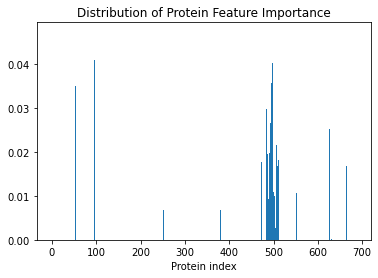

In [20]:
#Extract Feature Importance 
#finding the proteins having most dominant impact on growth rate)
proteom_importance = regr2.feature_importances_
#for i,v in enumerate(proteom_importance):print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(proteom_importance))], proteom_importance)
plt.xlabel("Protein index")
plt.xlabel("Protein index")
plt.title("Distribution of Protein Feature Importance")
plt.savefig("Distribution of Protein Feature Importance.jpeg")
plt.show()

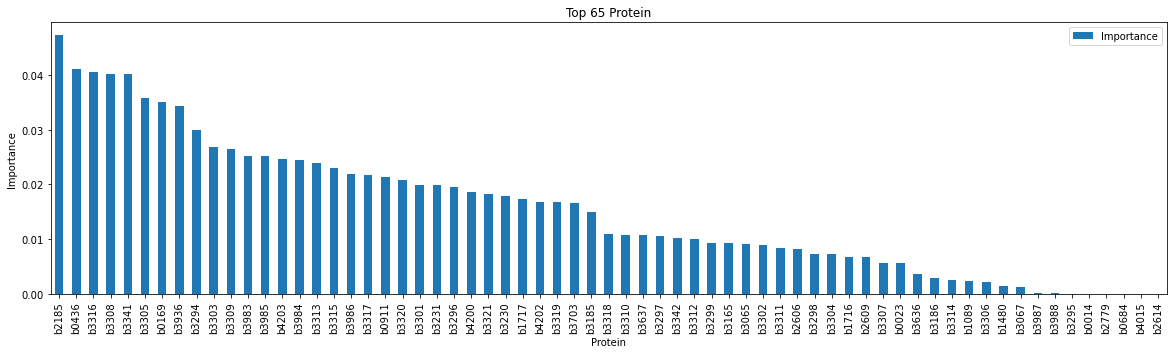

In [21]:
#60 of 684 proteins are significant in predicting cell Grwoth 

proteom_importance = pd.DataFrame(proteom_importance,columns=['Importance'], index=features.drop(features[0]))
proteom_importance=proteom_importance.sort_values(by='Importance', ascending=False)

proteom_importance.to_csv('Protein_Feature_Importance.csv',index=True)

ax=proteom_importance.head(65).plot.bar(figsize=(20,5))
ax.set_xlabel("Protein")
ax.set_ylabel("Importance")
ax.set_title("Top 65 Protein")
plt.savefig("Significant_Protein.jpeg")

In [22]:
proteom_importance.head(10).index

Index(['b2185', 'b0436', 'b3316', 'b3308', 'b3341', 'b3305', 'b0169', 'b3936',
       'b3294', 'b3303'],
      dtype='object')

In [23]:
ME_10= ME_cleaned.filter(items=['T_x','pH_x','ROS_x','b2185', 'b3341', 'b0436', 'b3316', 'b3308', 'b0169', 'b3936', 'b3305',
       'b3294', 'b3303'])
ME_10

,T_x,pH_x,ROS_x,b2185,b3341,b0436,b3316,b3308,b0169,b3936,b3305,b3294,b3303
0,26,5.0,0.1,0.000787,0.001465,0.003545,0.000759,0.001485,0.001958,0.000580,0.001382,0.001058,0.001286
1,26,5.0,0.5,0.000772,0.001435,0.003474,0.000744,0.001456,0.001919,0.000569,0.001355,0.001037,0.001261
2,26,5.0,1.0,0.000764,0.001421,0.003439,0.000736,0.001441,0.001900,0.000563,0.001341,0.001027,0.001248
3,26,5.0,10.0,0.000620,0.001153,0.002791,0.000597,0.001169,0.001542,0.000457,0.001088,0.000833,0.001013
4,26,5.0,2.0,0.000748,0.001391,0.003368,0.000721,0.001411,0.001860,0.000551,0.001313,0.001005,0.001222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,45,7.0,0.5,0.000981,0.001824,0.004417,0.000945,0.001850,0.002439,0.000733,0.001722,0.001318,0.001602
1073,45,7.0,1.0,0.000976,0.001816,0.004397,0.000941,0.001841,0.002428,0.000730,0.001714,0.001312,0.001595
1074,45,7.0,10.0,0.000900,0.001675,0.004055,0.000868,0.001698,0.002240,0.000673,0.001581,0.001210,0.001471
1075,45,7.0,2.0,0.000967,0.001800,0.004357,0.000932,0.001824,0.002406,0.000723,0.001698,0.001300,0.001581


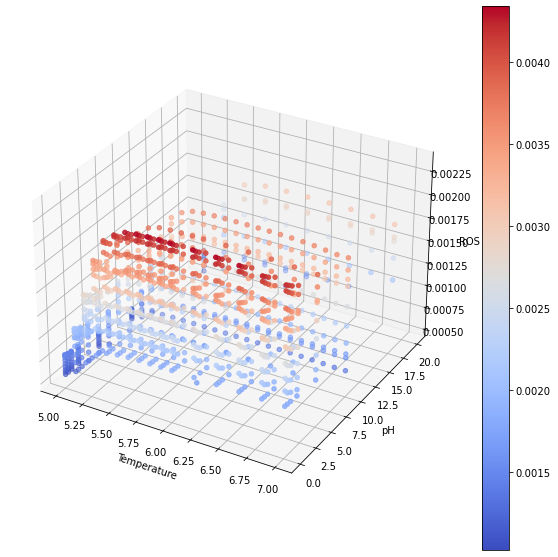

<Figure size 432x288 with 0 Axes>

In [24]:
#A sample 3D Plot of the top 1 protein (B2185) and its response given a range of pH, ROS, Temperature
#Similar plot can be plotted to other Top Proteins

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d',xlabel='Temperature',ylabel='pH', zlabel='ROS')

x = ME_10.iloc[:,1]
y = ME_10.iloc[:,2]
z = ME_10.iloc[:,3]
c = ME_10.iloc[:,4]

img = ax.scatter(x, y, z, c=c, cmap='coolwarm')

fig.colorbar(img)
plt.show()
plt.savefig("B2185_Response_to_Stress.jpeg")

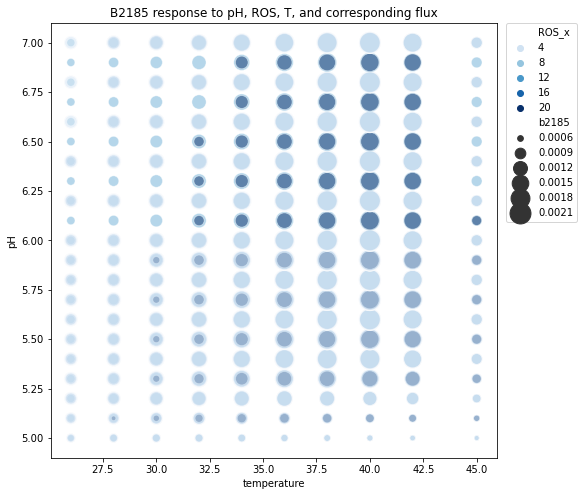

In [25]:
#An example of Protein flux response to pH, ROS, T 
#In the graph, the color of the circle denote ROS level, while the size of the circle denotes the flux

plt.figure(figsize=(8,8))
sns.scatterplot(x="T_x", 
                y="pH_x",
                size="b2185",
                sizes=(20,500),
                alpha=0.5,
                hue='ROS_x',
                data=ME_10,
                palette="Blues"
               )

plt.legend(bbox_to_anchor=(1.02, 1),borderaxespad=0)

plt.xlabel("temperature")
plt.ylabel("pH")
plt.title("B2185 response to pH, ROS, T, and corresponding flux")

plt.savefig("B2185_response_to_stress_and_corresponding_flux.jpeg")
 

In [26]:
#It is obvious that there are some proteins demostrate "On" and "Off" trend when stress reach certain level
#Therefore, it is important to capture these "on and off" trend
#Filter the dataset again, keeping the protein that have "zero-expression" only
#then, convert fluxes to binary

ME_binary = ME_merged.drop(columns=['Stress','T_y','pH_y','ROS_y','growth_rate'])
ME_binary = ME_binary.loc[:, (ME_binary == 0).any(axis=0)]
ME_binary = pd.concat([ME_protemo.iloc[:,1:4],ME_binary], axis=1)

ME_binary[ME_binary.iloc[:,3:]!= 0] = 1

# Assign T, pH, ROS into different catagories
# LOW_ROS : ROS< 1X
# NORMAL_ROS : ROS= 1X
# HIGH_ROS : ROS>1X
# LOW_T: T < T mean
# Medium_T: T = T mean
# HIGH_T: T > T mean
# LOW_pH: pH< pH mean
# Medium_pH: pH= pH mean
# Neutral: pH=7

bins_1 = [0.1,1,2]
ROS_Cat = ['LOW_ROS', 'NORMAL_ROS', 'HIGH_ROS']
d = dict(enumerate(ROS_Cat, 1))
ME_binary['ROS'] = np.vectorize(d.get)(np.digitize(ME_binary['ROS'], bins_1))

bins_2 = [ME_binary['T'].min(),ME_binary['T'].mean(),ME_binary['T'].max()]
Temp_Cat = ['LOW_T', 'Medium_T', 'HIGH_T']
d = dict(enumerate(Temp_Cat, 1))
ME_binary['T'] = np.vectorize(d.get)(np.digitize(ME_binary['T'], bins_2))

bins_3 = [ME_binary['pH'].min(),ME_binary['pH'].mean(),ME_binary['pH'].max()]
pH_Cat = ['LOW_pH', 'Medium_pH', 'Neutral']
d = dict(enumerate(pH_Cat, 1))
ME_binary['pH'] = np.vectorize(d.get)(np.digitize(ME_binary['pH'], bins_3))

ME_binary=ME_binary.groupby(['T','pH','ROS']).sum()


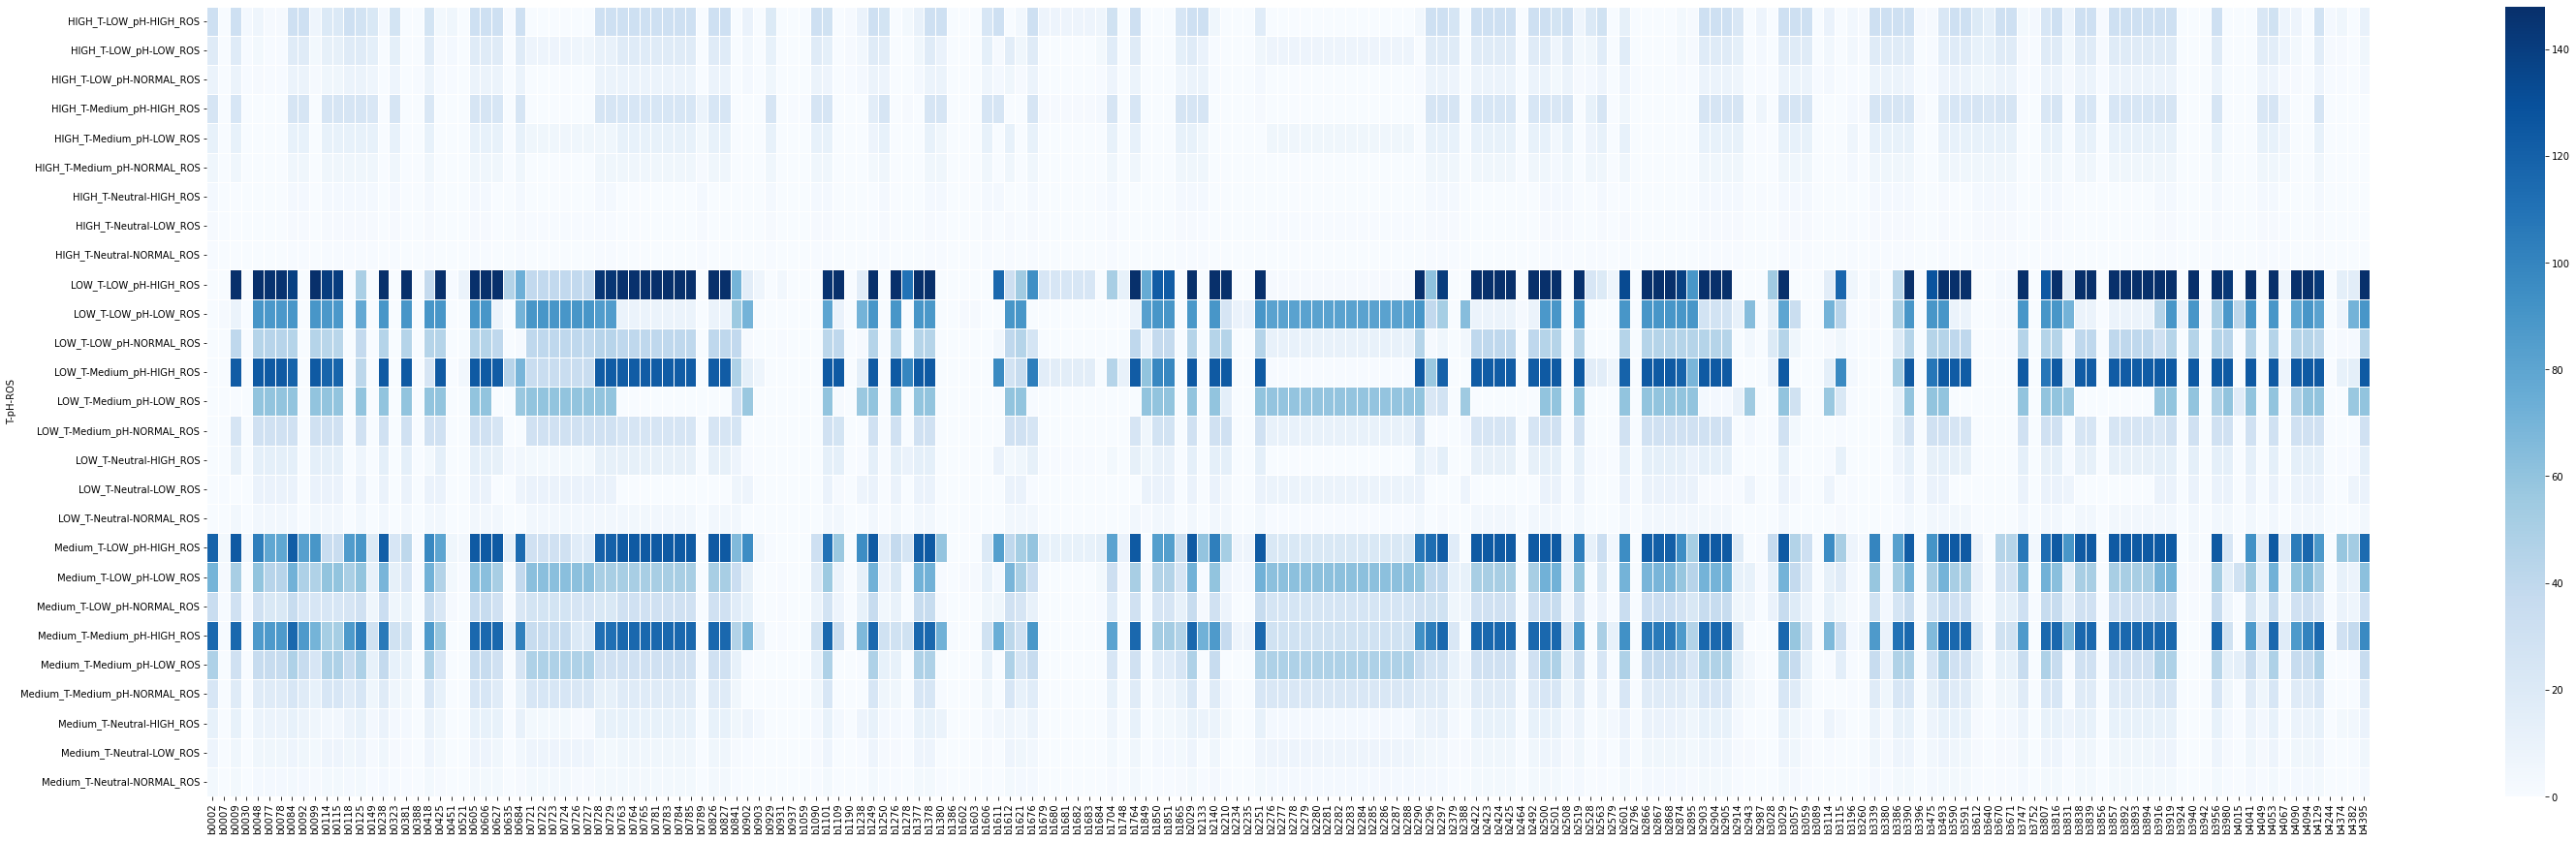

In [27]:
#Count Frequency in each catagories

plt.figure(figsize=(50,15))
sns.heatmap(ME_binary, cmap="Blues", fmt="g", cbar=True, linewidth=0.5)
#ax.set_aspect("equal")
plt.savefig('Flux_binary_heatmap.jpeg')

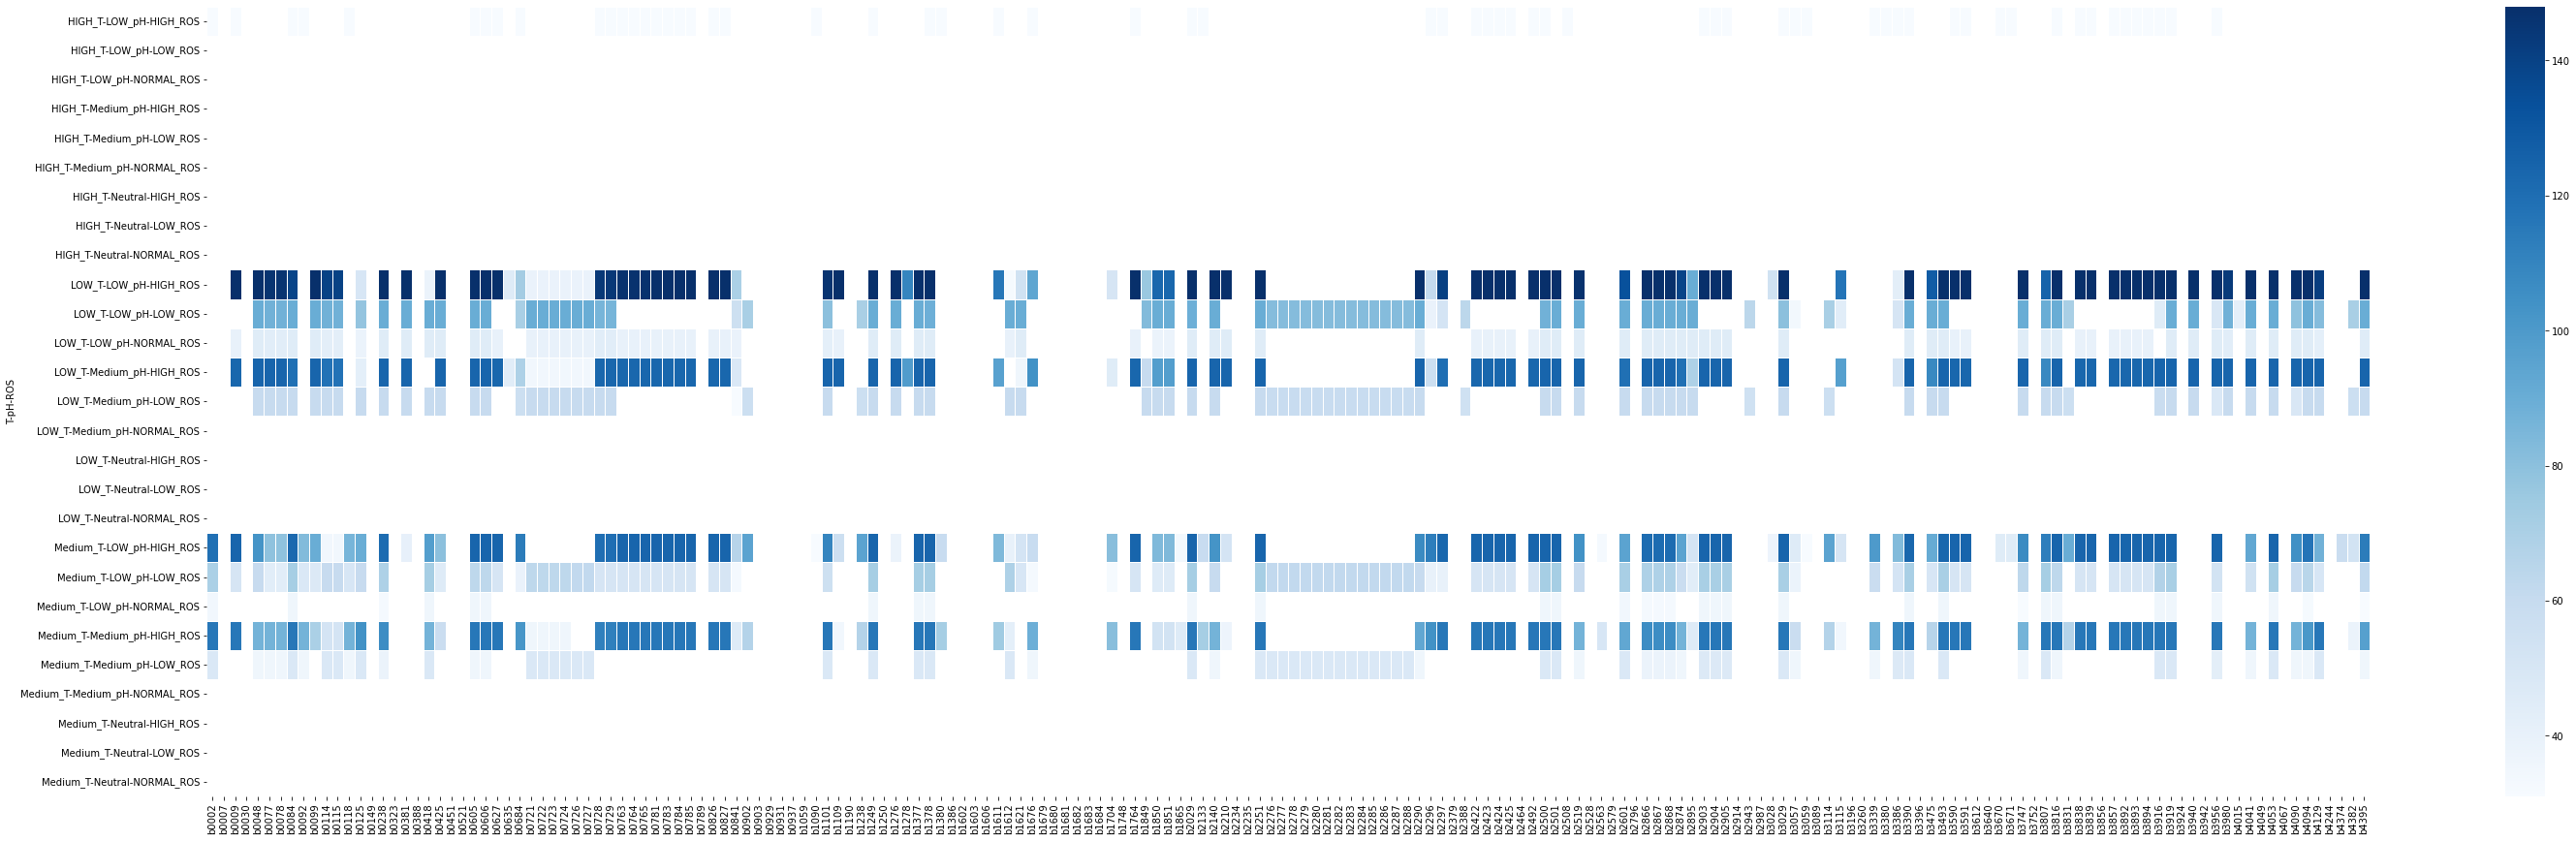

In [28]:
# Filter out the data frequency less than 30 to get cleaner groups

ME_binary_30 = ME_binary[ME_binary>30]
plt.figure(figsize=(50,15))
sns.heatmap(ME_binary_30, cmap="Blues", fmt="g", cbar=True, linewidth=0.5)
#ax.set_aspect("equal")
plt.savefig('Flux_binary_filtered_heatmap.jpeg')

In [29]:
# Now build a PAM (Partitioning Around Medoids) clustering algorithem to determine the hiden pattern in the flux
# KMedoids is used for binary data

# aim: find the protein that tend to express together

ME_binary_PAM = ME_merged.drop(columns=['Stress','T_x','pH_x','ROS_x','T_y','pH_y','ROS_y','growth_rate'])
ME_binary_PAM = ME_binary_PAM.loc[:, (ME_binary_PAM == 0).any(axis=0)]
ME_binary_PAM[ME_binary_PAM.iloc[:,:]!= 0] = 1

[Text(0.5, 0, 'Threshold'), Text(0, 0.5, ' Expression frequency')]

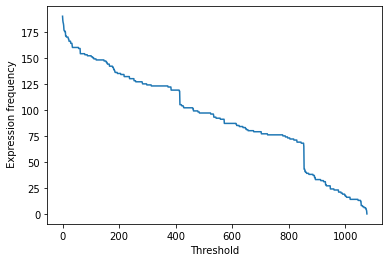

In [30]:
# based on the heatmap, we can see there are some protein not expressing no matter what conditions they are
# We need filter those proteins if total apperaence is less than a certain number 

Test = ME_binary_PAM.copy()
num_proteins = []
counts = Test.sum()
for i in range(len(Test.index)):
    counts = Test.sum()
    Test= Test[counts[counts > i].index]
    #counts.append(i)
    num_proteins.append(len(Test.columns))
    
x= np.arange(0,len(Test.index))

ax2=sns.lineplot(x = x, y = num_proteins)
ax2.set(xlabel='Threshold', ylabel=' Expression frequency')


In [31]:
#50 seems to be a resonable threshold
counts = ME_binary_PAM.sum()
threshold = 50
ME_binary_PAM= ME_binary_PAM[counts[counts > threshold].index]
X_PAM = ME_binary_PAM.to_numpy()

In [32]:
# Perform a quick PCA to determine the number of clusters present

pca = PCA(n_components=50)
pca.fit_transform(X_PAM)
print(pca.explained_variance_ratio_.cumsum())

[0.34900605 0.58359782 0.67342789 0.74601574 0.78822225 0.81474684
 0.83556098 0.85491412 0.86959156 0.88100985 0.89058972 0.89952694
 0.90797748 0.91494008 0.92088889 0.92668648 0.93220273 0.93702913
 0.94159006 0.94577869 0.94982583 0.9537897  0.95724136 0.96027594
 0.96286804 0.96531409 0.96763928 0.96964573 0.9714348  0.97314556
 0.97485221 0.97646497 0.97795591 0.97941206 0.98077691 0.9819934
 0.98311994 0.98421294 0.98520503 0.98617217 0.98711223 0.98798732
 0.98878168 0.98953239 0.99026808 0.99095962 0.99160429 0.99222982
 0.99280472 0.99335785]


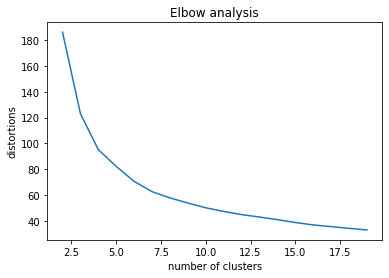

In [33]:
#Looks like there 6 clusters will be sufficent to explain >80 variance

#Setting up a PAM clustering based on Hamming Distance

#Verifying it via a elbow analysis

inertia = []
K=[]
for k in range(2,20):
    kmedoids = KMedoids(n_clusters=k, random_state=3, metric='hamming',method='pam').fit(X_PAM)
    inertia.append(kmedoids.inertia_)
    K.append(k)
ax = sns.lineplot(x = K, y = inertia);

ax.set(xlabel='number of clusters', ylabel='distortions')
ax.set(title='Elbow analysis')

plt.savefig("Elbow_analysis_of_flux_clusters.jpeg")

In [34]:
#Setting n_clusters to 6

kmedoids = KMedoids(n_clusters=6, random_state=3, metric='hamming',method='pam').fit(X_PAM)

X_clustered = pd.DataFrame(ME_binary_PAM, columns=ME_binary_PAM.columns, index=ME_binary_PAM.index)
X_clustered['cluster'] = kmedoids.labels_

X_clustered.head()


,b0002,b0009,b0048,b0077,b0078,b0084,b0092,b0099,b0114,b0115,...,b4049,b4053,b4067,b4090,b4094,b4129,b4374,b4382,b4395,cluster
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5
2,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2
3,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2
4,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2


In [35]:
PAM_results = X_clustered.groupby(['cluster']).sum()

In [36]:
PAM_results

,b0002,b0009,b0048,b0077,b0078,b0084,b0092,b0099,b0114,b0115,...,b4041,b4049,b4053,b4067,b4090,b4094,b4129,b4374,b4382,b4395
cluster,,,,,,,,,,,,,,,,,,,,,
0,187.0,180.0,4.0,0.0,0.0,187.0,187.0,4.0,172.0,172.0,...,0.0,174.0,186.0,52.0,6.0,32.0,186.0,1.0,0.0,33.0
1,44.0,0.0,206.0,204.0,204.0,206.0,3.0,206.0,206.0,206.0,...,206.0,0.0,206.0,2.0,183.0,206.0,200.0,7.0,137.0,206.0
2,31.0,242.0,244.0,242.0,242.0,228.0,0.0,244.0,240.0,240.0,...,244.0,0.0,244.0,19.0,244.0,244.0,235.0,13.0,13.0,244.0
3,145.0,140.0,146.0,139.0,139.0,148.0,133.0,94.0,96.0,96.0,...,142.0,3.0,148.0,17.0,146.0,147.0,136.0,16.0,33.0,148.0
4,116.0,122.0,121.0,75.0,75.0,122.0,98.0,100.0,0.0,0.0,...,97.0,0.0,118.0,14.0,122.0,114.0,65.0,85.0,62.0,122.0
5,20.0,170.0,170.0,169.0,169.0,170.0,0.0,170.0,143.0,143.0,...,170.0,0.0,170.0,3.0,170.0,170.0,163.0,37.0,38.0,170.0


<AxesSubplot:ylabel='cluster'>

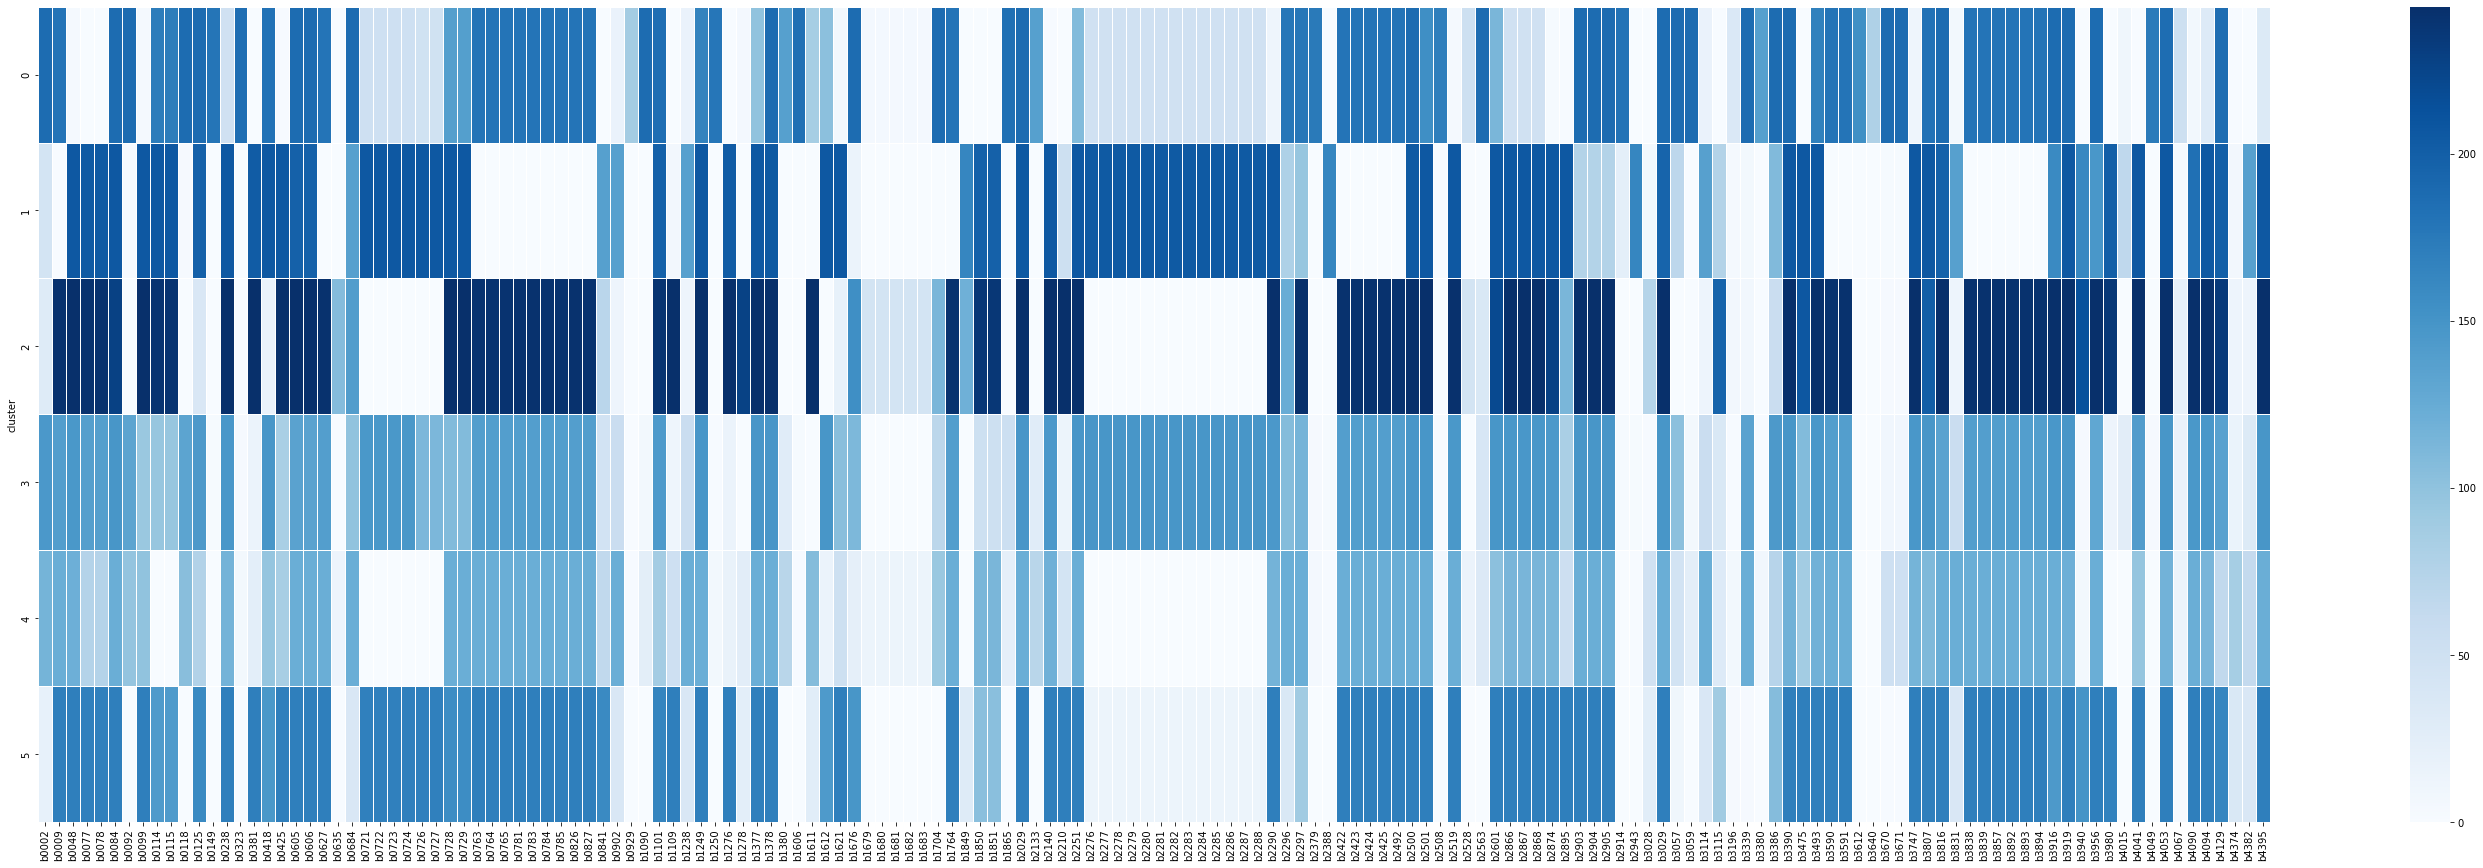

In [37]:
plt.figure(figsize=(50,15))
sns.heatmap(PAM_results, cmap="Blues", fmt="g", cbar=True, linewidth=0.5)

#ax.set_aspect("equal")


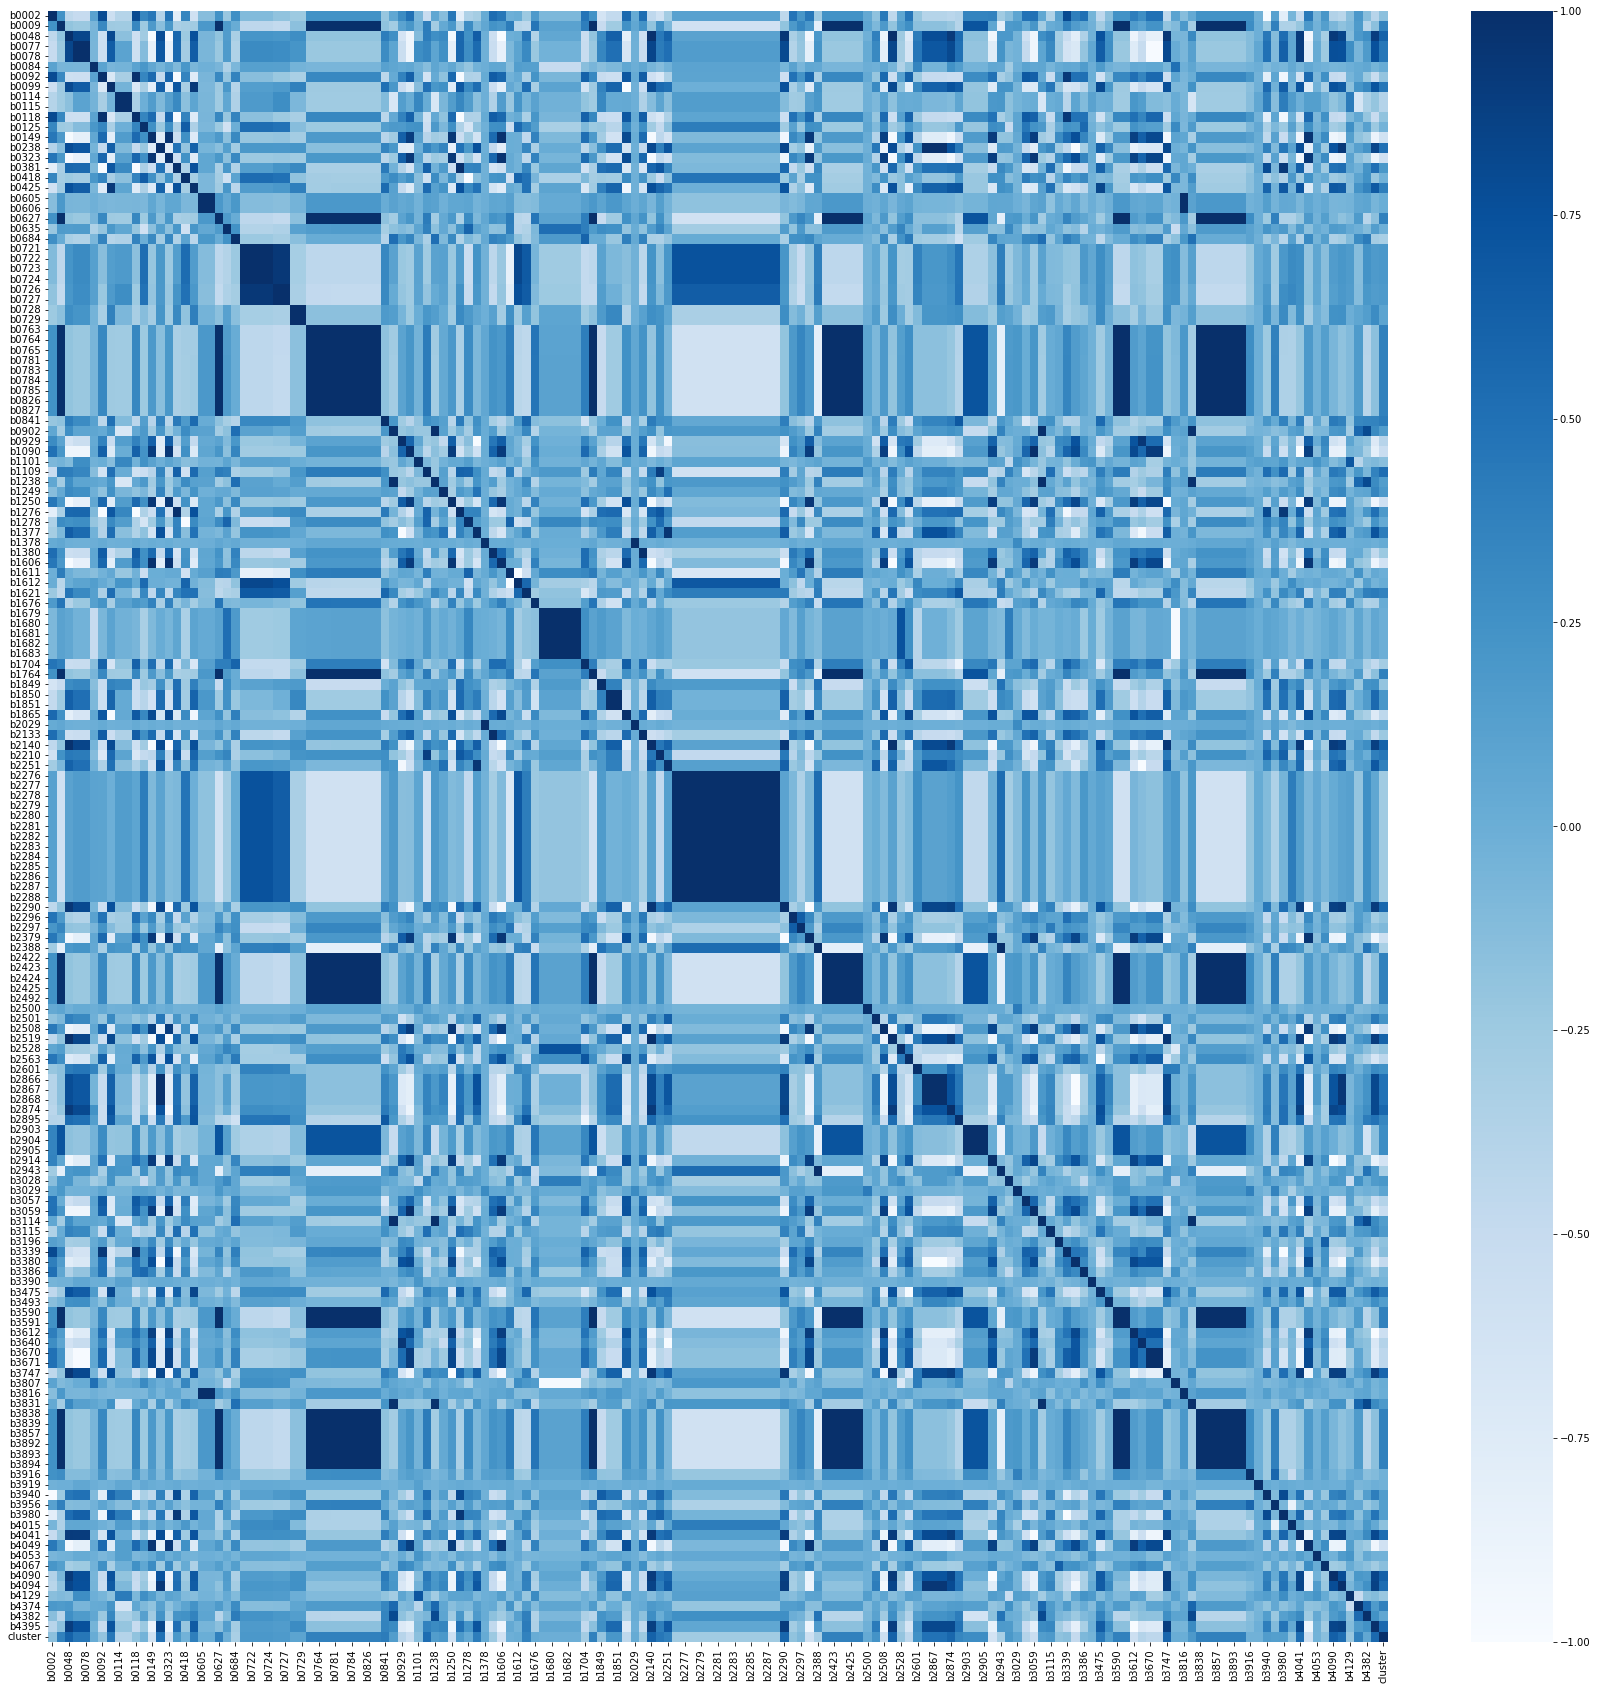

In [38]:
# finally we want to build a model that can predict:
# whether these prtein are expressed or not expressed at given stress
plt.figure(figsize=(30,30))
corr_matrix = ME_binary_PAM.corr()
sns.heatmap(corr_matrix, annot=False,cmap="Blues")
plt.show()


In [39]:
corr_matrix

,b0002,b0009,b0048,b0077,b0078,b0084,b0092,b0099,b0114,b0115,...,b4049,b4053,b4067,b4090,b4094,b4129,b4374,b4382,b4395,cluster
b0002,1.000000,0.244886,-0.453094,-0.493878,-0.493878,0.108481,0.794438,-0.558013,-0.396506,-0.396506,...,0.439781,-0.067726,0.211408,-0.373675,-0.420298,-0.143615,0.192838,-0.142117,-0.405070,-0.158873
b0009,0.244886,1.000000,-0.191039,-0.230508,-0.230508,-0.062752,0.324836,-0.250007,-0.258907,-0.258907,...,0.183331,-0.034899,0.139077,-0.073724,-0.171931,-0.106981,0.167449,-0.408191,-0.162907,0.381109
b0048,-0.453094,-0.191039,1.000000,0.835351,0.835351,-0.056107,-0.570333,0.811978,-0.158379,-0.158379,...,-0.944103,-0.031204,-0.299905,0.920755,0.838737,-0.139635,0.190149,0.272773,0.894009,0.612226
b0077,-0.493878,-0.230508,0.835351,1.000000,1.000000,-0.067166,-0.556192,0.657234,0.094859,0.094859,...,-0.810806,0.027533,-0.245967,0.760179,0.750333,0.274707,-0.064579,0.171201,0.746811,0.452978
b0078,-0.493878,-0.230508,0.835351,1.000000,1.000000,-0.067166,-0.556192,0.657234,0.094859,0.094859,...,-0.810806,0.027533,-0.245967,0.760179,0.750333,0.274707,-0.064579,0.171201,0.746811,0.452978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4129,-0.143615,-0.106981,-0.139635,0.274707,0.274707,-0.010071,-0.054716,-0.164196,0.421922,0.421922,...,0.135532,0.223466,0.023767,-0.148628,-0.074053,1.000000,-0.500230,-0.164726,-0.124835,-0.221042
b4374,0.192838,0.167449,0.190149,-0.064579,-0.064579,0.029471,0.031363,0.234180,-0.652605,-0.652605,...,-0.184562,-0.164101,-0.094473,0.202396,0.110820,-0.500230,1.000000,0.548426,0.169995,0.375633
b4382,-0.142117,-0.408191,0.272773,0.171201,0.171201,0.055876,-0.227515,0.335936,-0.330649,-0.330649,...,-0.264758,0.040773,-0.163023,0.166974,0.253029,-0.164726,0.548426,1.000000,0.243861,0.062182
b4395,-0.405070,-0.162907,0.894009,0.746811,0.746811,-0.050160,-0.509883,0.725916,-0.206957,-0.206957,...,-0.899601,-0.027896,-0.272218,0.839914,0.860416,-0.124835,0.169995,0.243861,1.000000,0.560442


In [40]:
#Firstly, try an MultiOutputClassifier based on SupportVector Machine Classifier

ME_svm= ME_binary_PAM.copy()
ME_svm= ME_svm.drop(columns=['cluster'])
X_svm= ME_phenotypes.iloc[:,1:4]
y_svm = ME_svm.loc[:, (ME_svm == 0).any(axis=0)]
y_svm[y_svm!= 0] = 1

Xtrain_svm, Xtest_svm, ytrain_svm, ytest_svm =train_test_split(X_svm, y_svm, train_size=0.8, random_state=0)

svc = SVC(gamma="scale")
model = MultiOutputClassifier(estimator=svc)

print(model)
MultiOutputClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=500,
                                    class_weight=None, coef0=0.0,
                                    decision_function_shape='ovr', degree=3,
                                    gamma='scale', kernel='rbf', max_iter=-1,
                                    probability=False, random_state=None,
                                    shrinking=True, tol=0.001, verbose=False),
                      n_jobs=None) 

model.fit(Xtrain_svm, ytrain_svm)
print(model.score(Xtrain_svm, ytrain_svm))


MultiOutputClassifier(estimator=SVC())
0.030197444831591175


In [41]:
#The SVM did not yield good accuracy
#We have to rely on deep learning again
#In this case, the sigmoid function is used to enable binary labeling
#binary crossentropy loss is used

input_shape = (3,) 
model2=Sequential()
model2.add(Dense(3, input_shape=input_shape, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))

model2.add(Dense(160, activation='sigmoid'))

#model.add(SeqSelfAttention(attention_activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=(['mean_absolute_error','accuracy']))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 3)                 12        
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 160)               10400     
                                                                 
Total params: 27,244
Trainable params: 27,244
Non-trainable params: 0
_________________________________________________________________


In [69]:
#start with small batch size (1) 3000
#once accuracy above 60% , use big step, batch size 200, 500 epochs, multiple times
# plateu at ~95


history2= model2.fit(Xtrain_svm,
                   ytrain_svm,
                   epochs=1000,
                   batch_size=50,
                   verbose=1,
                   validation_data=(Xtest_svm,ytest_svm))

Epoch 1/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0236 - mean_absolute_error: 0.0165 - accuracy: 0.8897 - val_loss: 0.3524 - val_mean_absolute_error: 0.0405 - val_accuracy: 0.8611
Epoch 2/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0271 - mean_absolute_error: 0.0182 - accuracy: 0.8931 - val_loss: 0.3631 - val_mean_absolute_error: 0.0392 - val_accuracy: 0.8565
Epoch 3/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0365 - mean_absolute_error: 0.0211 - accuracy: 0.8885 - val_loss: 0.3841 - val_mean_absolute_error: 0.0422 - val_accuracy: 0.8981
Epoch 4/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.0849 - mean_absolute_error: 0.0301 - accuracy: 0.8966 - val_loss: 0.6012 - val_mean_absolute_error: 0.0511 - val_accuracy: 0.9074
Epoch 5/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.1520 - mean_absolute_error: 0.0393 - accuracy: 0.9094 - val_loss: 0.4294 - val_mean_absolute_error: 

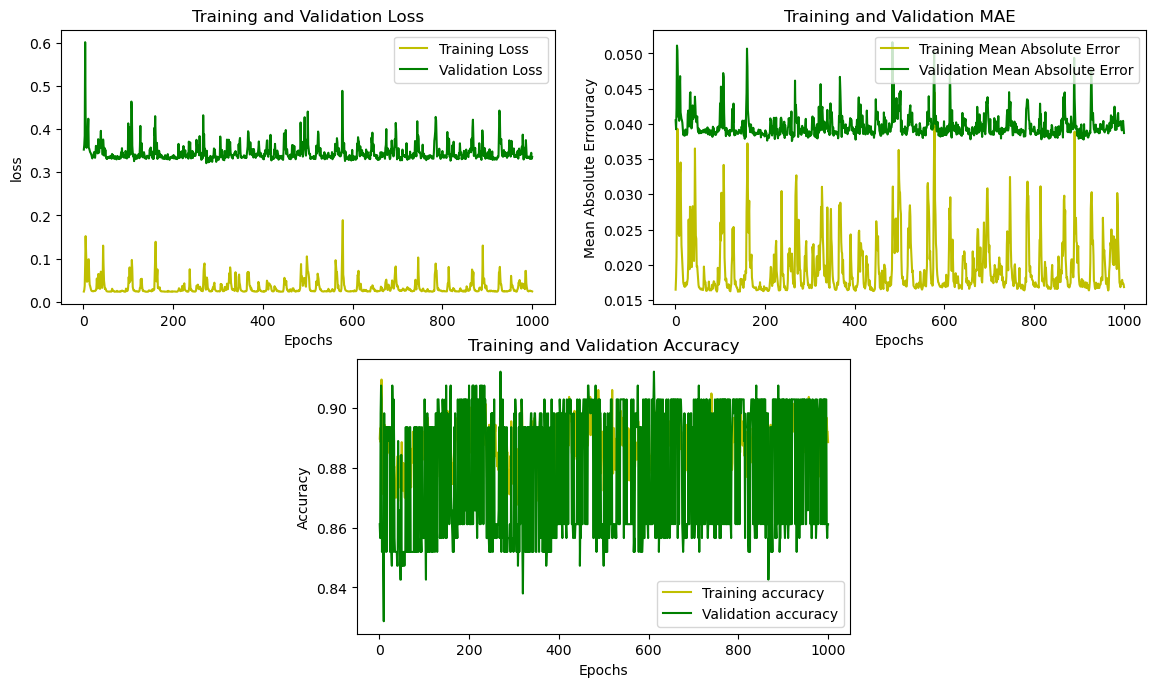

In [70]:
#Generate Metrics plots for MLP Classifier LOSS, MSE, Accuracy

fig, ax = plt.subplots(3, figsize=(14,8),dpi=100)

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

loss = history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(loss)+1)
ax1.plot(epochs,loss,'y',label='Training Loss')
ax1.plot(epochs,val_loss,'g', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('loss')
ax1.legend()

MAE= history2.history['mean_absolute_error']
val_MAE = history2.history['val_mean_absolute_error']
ax2.plot(epochs, MAE, 'y', label= 'Training Mean Absolute Error')
ax2.plot(epochs, val_MAE , 'g', label= 'Validation Mean Absolute Error')
ax2.set_title('Training and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Absolute Erroruracy')
ax2.legend()

acc= history2.history['accuracy']
val_acc = history2.history['val_accuracy']
ax3.plot(epochs, acc, 'y', label= 'Training accuracy')
ax3.plot(epochs, val_acc , 'g', label= 'Validation accuracy')
ax3.set_title('Training and Validation Accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()

plt.savefig('MLP_classifier_Scores.jpeg')


In [74]:
#Checking R^2 SCORE
prediction2 = model2.predict(Xtest_svm[:1])
df3 = ME_svm.loc[:, (ME_svm == 0).any(axis=0)]

Predicted2_df = pd.DataFrame(prediction2, columns=df3.columns)
Target2_df = pd.DataFrame(ytest_svm[:1], columns=df3.columns)
Results2_df = pd.concat([Predicted2_df,Target2_df]).T
Results2_df.columns = ['Predicted Values', 'Target Values']
Results2_df.head(50)

#Results_df.plot.bar(figsize=(30,10))

1/1 [==============================] - 0s 66ms/step


,Predicted Values,Target Values
b0002,0.000000e+00,0.0
b0009,0.000000e+00,0.0
b0048,1.000000e+00,1.0
b0077,1.000000e+00,1.0
b0078,1.000000e+00,1.0
b0084,1.000000e+00,1.0
b0092,0.000000e+00,0.0
b0099,1.000000e+00,1.0
b0114,1.000000e+00,1.0
b0115,1.000000e+00,1.0


In [75]:
model2.save("MLP_binary.h5")

In [76]:
# finally we can construct a pipline, that use NN regressor to predict total protein flux 
# with NN binary classifier to filter key proteins

def flux_prediction (Stress_conditions):
    
    model_general = load_model('model1.h5')
    model_binary = load_model('model2.h5')
    
    Flux_general = model_general.predict([Stress_conditions])
    Flux_binary = model_binary.predict([Stress_conditions])
    
    return Flux_general, Flux_binary

#Threshold_2 = 1e-7

def force_binary(Threshold_2):   
    for i in range (len(Flux_binary)):
        if Flux_binary[i]<Threshold_2:
            Flux_binary[i]=0
    else:
        Flux_binary[i]=1  
        
    return Flux_binary
    
def prediction_result (Flux_general, Flux_binary):
    df_Flux_general = pd.DataFram (Flux_general, 
                                   columns= ME_protemo.drop(columns=['Stress', 'T', 'pH', 'ROS']).columns)
    df_Flux_binary = pd.DataFram (Flux_binary, 
                                   columns= ME_protemo.drop(columns=[results.columns]))
    df_Prediction= np.where(df_Flux_binary == 0, df_Flux_general, df_Flux_binary)
    